###
Bikes_gdf:
    Capacity
Lights_gdf:
	lamp_type_lupvalue	
    lamp_rating_w
Landmarks:


In [1]:
import pandas as pd
import geopandas as gpd
from IPython.display import Image
from shapely.geometry import Point, Polygon
import folium
import numpy as np
from shapely.ops import transform
import pyproj

buffer_size= 100

### Functions

In [18]:
def create_features_gdf (fp):
    # Read in csv
    feature_df = pd.read_csv(fp)
    # Convert to geodataframe
    feature_gdf = gpd.GeoDataFrame(feature_df, geometry=gpd.points_from_xy(feature_df['Longitude'], feature_df['Latitude']))
    feature_gdf.set_crs(epsg=4326, inplace=True)
    
    return feature_gdf

# Count the number of the broken down classes in each sensor
def feature_types (gdf, grouping_col_name):

    # Create a dataframe to store the results for each sensor
    num_feature_each_type_all_sensors = pd.DataFrame({grouping_col_name : gdf[grouping_col_name].unique()})
    
    # Loop through each sensor (in ascending order)
    for sensor_num in sorted(sensors_gdf['sensor_id'].unique().tolist()):

        # Get geodataframe from just this sensor
        this_sensor_gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
        this_sensor_gdf.reset_index(inplace = True, drop = True)

        # Create list to store rows with a feature within the sensor's radius 
        features_in_radius = []

        # Loop through each feature, check if it is found within the radius of the sensor
        # if it is, then adds the row to the list containing features found within the radius
        for index, row in gdf.iterrows():
            if this_sensor_gdf['polygon'][0].contains(row.geometry):
                # Add row for feature within the radius to list
                features_in_radius.append(row)

        # If there are no features at all within radius, then apply a 0 to each of the feature
        # types for this sensor in the table
        if len(features_in_radius)==0:
            num_feature_each_type_all_sensors[sensor_num] = 0 * len(num_feature_each_type_all_sensors)
        # If there is at least one feature, then create a dataframe with the number of each type of feature
        else:
            # Create a dataframe containing data for all features within the radius of this sensor
            features_in_radius_df = pd.DataFrame(features_in_radius)
            # Find the number of features of each type within the radius of this sensor
            features_in_radius_by_type_df = features_in_radius_df.groupby(grouping_col_name).agg({'geometry': 'count'})
            # Add theme as a column        
            features_in_radius_by_type_df.insert(0, grouping_col_name, features_in_radius_by_type_df.index)
            # Reset index (so theme is no longer the index)
            features_in_radius_by_type_df.reset_index(inplace=True, drop = True)
            features_in_radius_by_type_df.rename(columns={"geometry": sensor_num}, inplace = True)

            # Add to dataframe for all the sensors
            num_feature_each_type_all_sensors = num_feature_each_type_all_sensors.merge(features_in_radius_by_type_df, on=grouping_col_name, how='left')

    # Replace NaNs with 0        
    num_feature_each_type_all_sensors = num_feature_each_type_all_sensors.fillna(0)      

    return num_feature_each_type_all_sensors

## Function to find the number of features near to a sensor
# from one geodataframe of features for one sensor
def find_num_features_near_sensor (sensor_num, gdf, buffer_size_m):
    
    # Convert CRS of sensor data to one that works with finding the radius
    global sensors_gdf
    reprojected_sensors = sensors_gdf.copy()
    reprojected_sensors.to_crs(crs=3577, inplace = True)

    # Draw a buffer around each sensor in metres
    reprojected_sensors['polygon'] = reprojected_sensors.geometry.buffer(buffer_size_m)   

    # Get geodataframe from just this sensor
    this_sensor_gdf = reprojected_sensors[reprojected_sensors.sensor_id == sensor_num]
    this_sensor_gdf.reset_index(inplace = True, drop = True)

    # set up reprojection
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3577'), always_xy=True).transform

    # Check if each of the features is within the radius of this sensor
    features_in_radius = []
    for feature_location in gdf.geometry:
        transformed_point = transform(project, feature_location)
        if this_sensor_gdf['polygon'][0].contains(transformed_point):
            features_in_radius.append(feature_location)

    return (len(features_in_radius))

## Function to find the co-ordinates of all features near to a sensor
# from a dictionary containing several GDFs of features
def find_features_near_sensor (sensor_num, features_gdf_dict, buffer_size_m):
    
    # Convert CRS of sensor data to one that works with finding the radius
    global sensors_gdf
    reprojected_sensors = sensors_gdf.copy()
    reprojected_sensors.to_crs(crs=3577, inplace = True)
    
    # Draw a buffer around each sensor in metres
    reprojected_sensors['polygon'] = reprojected_sensors.geometry.buffer(buffer_size_m)   
    
    # Get geodataframe from just this sensor
    this_sensor_gdf = reprojected_sensors[reprojected_sensors.sensor_id == sensor_num]
    this_sensor_gdf.reset_index(inplace = True, drop = True)
    
    # set up reprojection
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3577'), always_xy=True).transform
    
    # Initialise dataframe to store results
    locations_of_features_in_radius = pd.DataFrame(None)
    
    # For each of the sets of features
    for name, gdf in features_gdf_dict.items():
        # Check if each of the features is within the radius of this sensor
        for feature_location in gdf.geometry:
            transformed_point = transform(project, feature_location)
            # If it is, construct a row containing its feature type, lat and long
            # And append to the dataframe containing location info on all features in the radius
            if this_sensor_gdf['polygon'][0].contains(transformed_point):
                row = pd.DataFrame({'feature_type': name, 'lat':feature_location.y, 'lon': feature_location.x}, index = [0])
                locations_of_features_in_radius = locations_of_features_in_radius.append(row, ignore_index=True)
    
    return locations_of_features_in_radius

# Sensors
## Read in the locations of the sensors

In [88]:
sensors_gdf = create_features_gdf('Data/melbourne_locations.csv')

## Draw a circle around each sensor, within which to look for features

In [90]:
# Filter out just the columns we want
sensors_gdf = sensors_gdf[['sensor_id', 'Latitude', 'Longitude', 'geometry']]

# Feature data

## Create geodataframe containing locations of features

In [5]:
buildings_gdf = create_features_gdf('Cleaned_data/buildings_clean.csv')
lights_gdf = create_features_gdf('Cleaned_data/lights_clean.csv')
furniture_gdf = create_features_gdf('Cleaned_data/street_inf_clean.csv')
bikes_gdf = create_features_gdf('Cleaned_data/bikes_clean.csv')
landmarks_gdf = create_features_gdf('Cleaned_data/landmarks_clean.csv')

# Create a dataframe documenting the number of each feature within the radius of each sensor
NB: If you use the full buildings_gdf with this method then it returns way too many buildings as each building is listed seperately in each year  
Can check this with:  
buildings_gdf[buildings_gdf.duplicated(['Longitude', 'Latitude'], keep=False)].sort_values(['Longitude', 'Latitude'])[0:12]

In [6]:
# Create a dictionary containing all the feature gdfs, and their names
gdfs = {'bikes': bikes_gdf, 'lights':lights_gdf, 'furniture': furniture_gdf, 'landmarks':landmarks_gdf}

# Add a gdf containing just the buildings present in each year to the dictionary of gdfs
for year in buildings_gdf.year.unique():
    this_year = buildings_gdf[buildings_gdf.year == year].copy()
    this_year.reset_index(inplace=True, drop = True)
    gdfs["buildings_{}".format(year)] = this_year    

In [9]:
## Create dataframe containing the number of each feature present in the radius of each sensor
# Create a dataframe with one column containing the sensor IDs
num_features_near_sensor = pd.DataFrame({'Sensor_ID': sorted(sensors_gdf['sensor_id'].unique().tolist())})

# For each GDF of features, check for each sensor the number of features from this set of features
# within that sensor's radius
for name, gdf in gdfs.items():
    num_features = []
    for sensor_num in sorted(sensors_gdf['sensor_id'].unique().tolist()):
        num_features_this_sensor = find_num_features_near_sensor(sensor_num, gdf, 100)
        num_features.append(num_features_this_sensor)
    num_features_near_sensor[name] = num_features 
# Print head    
num_features_near_sensor.head()    

,Sensor_ID,bikes,lights,furniture,landmarks,buildings_2010,buildings_2011,buildings_2012,buildings_2013,buildings_2014,buildings_2015,buildings_2016,buildings_2018,buildings_2020,buildings_2017,buildings_2019
0,1,0,56,256,2,31,31,30,30,30,30,30,30,30,30,30
1,2,0,34,257,2,31,31,30,30,30,30,30,30,30,30,30
2,3,1,28,153,1,24,24,24,24,24,24,24,24,24,24,24
3,4,0,0,193,2,35,35,35,35,35,35,35,35,35,35,35
4,5,0,23,138,0,1,1,1,1,1,1,1,1,1,1,1


# Return the number of each feature associated with a specific sensor

In [11]:
sensor_num = 4
num_features_near_sensor[num_features_near_sensor['Sensor_ID']==sensor_num]

,Sensor_ID,bikes,lights,furniture,landmarks,buildings_2010,buildings_2011,buildings_2012,buildings_2013,buildings_2014,buildings_2015,buildings_2016,buildings_2018,buildings_2020,buildings_2017,buildings_2019
3,4,0,0,193,2,35,35,35,35,35,35,35,35,35,35,35


# Return dataframe with latitude and longitude of features in a specified sensor's radius

In [85]:
dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
filtered_gdfs = dictfilt(gdfs, ("bikes","lights", "landmarks", "furniture", "buildings_2011"))

# For one sensor, plot the features within its radius

In [126]:
sensor_num = 1
# Get dataframe of location of featurs in radius of this sensor
this_sensors_features = find_features_near_sensor(sensor_num, filtered_gdfs, 100)
# Get sensor data for one sensor
this_sensor = sensors_gdf[sensors_gdf['sensor_id'] ==sensor_num].copy()
# Convert the crs to 3577 - need to do this before doing the buffer
this_sensor.to_crs(crs=3577, inplace = True)
# Draw a buffer around this_sensor
this_sensor['polygon'] = this_sensor.geometry.buffer(100)   
this_sensor.reset_index(inplace=True, drop = True)
# Reconvert to projection for plotting
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:3577'), pyproj.CRS('EPSG:4326'), always_xy=True).transform
this_sensor['polygon'] = transform(project, this_sensor['polygon'][0])

In [127]:
# Plot
melbourne_map = folium.Map(location=[this_sensor.Latitude.mean(),
                           this_sensor.Longitude.mean()], zoom_start=18, control_scale=True)#, min_zoom = 13)
icon=folium.Icon(color="red")
# folium.CircleMarker([this_sensor["Latitude"], this_sensor["Longitude"]], popup=this_sensor["sensor_id"], 
#               color = 'red', fill = 'True', fill_opacity = True).add_to(melbourne_map)
folium.Marker([this_sensor["Latitude"], this_sensor["Longitude"]], popup=this_sensor["sensor_id"], icon = icon).add_to(melbourne_map)

# Add buffer zone
folium.GeoJson(data=this_sensor["polygon"][0]).add_to(melbourne_map)

# Add features
for index, location_info in this_sensors_features.iterrows():
    folium.CircleMarker([location_info["lat"], location_info["lon"]], popup=location_info["feature_type"],
    color = 'black', fill_color = 'white', fill = 'True', fill_opacity = True).add_to(melbourne_map)

melbourne_map

# Checking how much difference there actually is in buildings each year
#### Also, buildings only goes to 2019  - do we assume buildings in subsequent years are the same??

array([[<AxesSubplot:title={'center':'MaxDiffInBuildings_asprop'}>]],
      dtype=object)

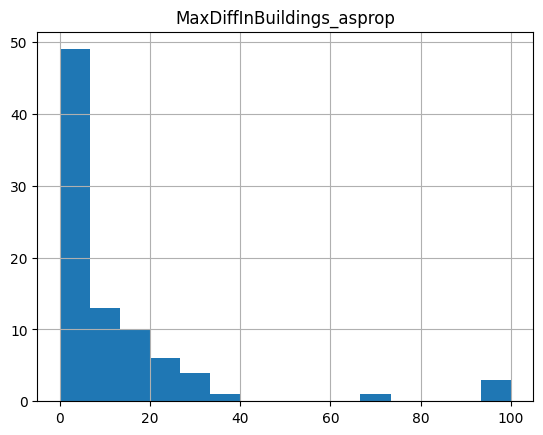

In [22]:
# Get just the buildings in a dataframe
just_buildings = num_features_near_sensor[['buildings_2011', 'buildings_2012', 'buildings_2013', 'buildings_2014', 'buildings_2015'
,'buildings_2016', 'buildings_2017', 'buildings_2018', 'buildings_2019']].copy()

# Find the maximum difference in the number of buildings near each sensor between the years
just_buildings['MaxDiffInBuildings'] = just_buildings.max(1) - just_buildings.min(1)
# Convert to a proportion of the amximum number of buildings in a year
just_buildings['MaxDiffInBuildings_asprop'] = round(just_buildings['MaxDiffInBuildings']/ just_buildings.max(1) *100,2)
just_buildings.head()

# Check the spread in difference with buildings
just_buildings.hist(column = 'MaxDiffInBuildings_asprop', bins=15)

In [39]:
# Some kind of category to denote a really tall building (not sure if an advantage to making it 
# categorical rather than continuous though)
building_gdf_2011 = gdfs["buildings_{}".format(2011)]
building_gdf_2011['HeightOfBuilding']= pd.cut(building_gdf_2011['n_floors'], bins=[0,3,20, 50, float('Inf')], labels=['small', 'medium', 'large', 'MASSIVE'])

# Create dataframes containing the number of sub-categories of features 

In [95]:
landmarks = feature_types(landmarks_gdf, 'theme')
furniture = feature_types(furniture_gdf, 'feature')
buildings_2012 = feature_types(gdfs['buildings_2012'], 'building_use')

## Find the buildings within the 'proximity' of each sensor, in a particular year

### returns dataframe with latitude and longitude points of light sources in a specified sensor's radius

In [99]:
# buildings

In [ ]:
def bike_locations(sensor_num):
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    sen_bikes = []
    for point in bike_gdf.geometry:
        for geo in gdf['polygon']:
            if geo.contains(point):
                sen_bikes.append(list(point.coords))
    bike_loc = [x[0] for x in sen_bikes]
    sensor_bikes = pd.DataFrame({'latitude': [x[0] for x in bike_loc], 'longitude': [x[1] for x in bike_loc]})
    return sensor_bikes

In [ ]:
bike_locations(3)

### create dataframe of all location points connected with sensor id

In [ ]:
sensor_bike_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = bike_locations(x)
    sensor_points['sensor_id'] = x
    sensor_bike_points = sensor_bike_points.append(sensor_points)

In [ ]:
sensor_bike_points.to_csv('./location features/features with locations/bike_points.csv', header = sensor_bike_points.columns, index=False)

### create dataframe of all location points connected with sensor id

In [ ]:
sensor_light_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = lights_locations(x)
    sensor_points['sensor_id'] = x
    sensor_light_points = sensor_light_points.append(sensor_points)

In [ ]:
sensor_light_points.to_csv('./location features/features with locations/light_points.csv', header = sensor_light_points.columns, index=False)

### List the number of lights in a sensor's radius

In [ ]:
light_dict = {}
keys = sensors.sensor_id.unique()
for k in keys:
    light_dict[k] = len(lights_locations(k))


In [ ]:
#convert dictionary to dataframe
lighting_df = pd.DataFrame(light_dict.items(), columns=['sensor_id', 'num_lights'])
lighting_df

In [ ]:
def lights_in_radius(sensor_num):
    return lighting_df[lighting_df.sensor_id == sensor_num]

In [ ]:
lights_in_radius(2)

# Landmarks

In [ ]:
 #zip lists of theme and point
landmark_zip_list =  list(zip(landmarks_gdf.theme,landmarks_gdf.geometry))
landmark_zip_list[:10]

### returns data frame with location coordinates and theme of landmarks in a sensor's radius

In [ ]:
def landmarks_coords(sensor_num):
    landmark_coord = []
    theme = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in landmark_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                landmark_coord.append(x[1])
                theme.append(x[0])
    zipped_sensor = list(zip(landmark_coord, theme))
    landmark = pd.DataFrame(zipped_sensor, columns = ['point', 'theme'])
    landmark['longitude'] = landmark.point.apply(lambda p: p.x)
    landmark['latitude'] = landmark.point.apply(lambda p: p.y)
    return landmark

In [ ]:
landmarks_coords(2)

### create dataframe of all location points connected with sensor id

In [ ]:
sensor_landmark_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = landmarks_coords(x)
    sensor_points['sensor_id'] = x
    sensor_landmark_points = sensor_landmark_points.append(sensor_points)

In [ ]:
sensor_landmark_points.to_csv('./location features/features with locations/landmark_points.csv', header = sensor_landmark_points.columns, index=False)

### returns number of different themes of landmarks in a sensor's radius

In [ ]:
def landmarks_in_radius(sensor_num):
    landmark_coord = []
    theme = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in landmark_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                landmark_coord.append(x[1])
                theme.append(x[0])
                
    if len(landmark_coord) > 0: 
        dicts = {}
        for x in landmarks.theme.unique():
            dicts[x] = 0
           
        zipped_sensor = list(zip(landmark_coord, theme))
        df_zip = pd.DataFrame(zipped_sensor, columns = ['point', 'theme'])
        group = df_zip.groupby('theme').agg({'point': 'count'})
        transform_group = group.T
        
        for col in transform_group.columns:
            dicts[col] = transform_group[col][0]
            
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df
    
    else:
        dicts = {}
        for x in landmarks.theme.unique():
            dicts[x] = 0
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df

In [ ]:
landmarks_in_radius(2)

In [85]:
#create list of type of features and point
furniture_zip_list =  list(zip(furniture_gdf['feature'],furniture_gdf['geometry']))
furniture_zip_list[:10]

[('Bicycle Rails', <shapely.geometry.point.Point at 0x7faeda952fd0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed7d5d3d0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed5fc57d0>),
 ('Bollard', <shapely.geometry.point.Point at 0x7faed7d5dc10>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed7d5dbd0>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faeda952c50>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed7d5db90>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed7d5dc90>),
 ('Bicycle Rails', <shapely.geometry.point.Point at 0x7faed7d5d050>),
 ('Litter Bin', <shapely.geometry.point.Point at 0x7faeda952a90>)]

In [ ]:
def furniture_coords(sensor_num):
    furniture_coord = []
    feature = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in furniture_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                furniture_coord.append(x[1])
                feature.append(x[0])
                
    zipped_sensor = list(zip(furniture_coord, feature))
    furniture = pd.DataFrame(zipped_sensor, columns = ['point', 'feature'])
    furniture['longitude'] = furniture.point.apply(lambda p: p.x)
    furniture['latitude'] = furniture.point.apply(lambda p: p.y)
    return furniture

In [ ]:
furniture_coords(2)

### create dataframe of all location points connected with sensor id

In [ ]:
sensor_furniture_points = pd.DataFrame([])
for x in sensors_gdf.sensor_id.unique():
    sensor_points = furniture_coords(x)
    sensor_points['sensor_id'] = x
    sensor_furniture_points = sensor_furniture_points.append(sensor_points)

In [ ]:
sensor_furniture_points.to_csv('./location features/features with locations/furniture_points.csv', header = sensor_furniture_points.columns, index=False)

### find number of features in sensor's radius, if there is none of a type, return 0

In [ ]:
def furniture_in_radius(sensor_num):
    furniture_coord = []
    feature = []
    gdf = sensors_gdf[sensors_gdf.sensor_id == sensor_num]
    for x in furniture_zip_list:
        for geo in gdf['polygon']:
            if geo.contains(x[1]):
                furniture_coord.append(x[1])
                feature.append(x[0])
                
    if len(furniture_coord) > 0: 
        dicts = {}
        for x in furniture_gdf['feature'].unique():
            dicts[x] = 0
           
        zipped_sensor = list(zip(furniture_coord, feature))
        df_zip = pd.DataFrame(zipped_sensor, columns = ['point', 'feature'])
        group = df_zip.groupby('feature').agg({'point': 'count'})
        transform_group = group.T
        
        for col in transform_group.columns:
            dicts[col] = transform_group[col][0]
            
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df
    
    else:
        dicts = {}
        for x in furniture_gdf['feature'].unique():
            dicts[x] = 0
        df = pd.DataFrame(dicts.items())
        df.set_index(df.columns[0], inplace = True)
        new_df = df.T
        new_df['sensor_id'] = sensor_num
        new_df.set_index('sensor_id', inplace = True)
        return new_df

In [ ]:
furniture_in_radius(2)

# Create a dataframe with all the features in a sensor's radius, per year

In [86]:
def sensor_features_per_year(sensor_num, year):
    return pd.concat([furniture_in_radius(sensor_num), landmarks_in_radius(sensor_num),  buildings_in_radius(sensor_num, buildings_per_year(year)),
           bike_df.loc[[sensor_num]], lighting_df.loc[[sensor_num]]], axis = 1)



In [87]:
sensor_features_per_year(2, 2012)

NameError: name 'furniture_in_radius' is not defined

## Make full dataframe per year, with all sensors that are valid for that period
yearly list of valid sensors is pulled from the data cleaning notebook

In [88]:
sensors_2011 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
sensors_2012 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
sensors_2013 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18]
sensors_2014 = [2,3,4,5,6,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
sensors_2015 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40]
sensors_2016 = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 53]
sensors_2017 = [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 37, 39, 40, 42, 43, 44, 53]
sensors_2018 = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
sensors_2019 = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58]

In [89]:
def features_per_year(year, year_list):
    year_df = pd.DataFrame([])
    for x in year_list:
        year_df = year_df.append(sensor_features_per_year(x, year))
        
    df = year_df.loc[:,~year_df.columns.duplicated()]
    #save to csv
    df.to_csv('./location features/features_{}.csv'.format(year), header = df.columns, index=True)
    
    

In [90]:
features_per_year(2011, sensors_2011)
features_per_year(2012, sensors_2012)
features_per_year(2013, sensors_2013)
features_per_year(2014, sensors_2014)
features_per_year(2015, sensors_2015)
features_per_year(2016, sensors_2016)
features_per_year(2017, sensors_2017)
features_per_year(2018, sensors_2018)

NameError: name 'furniture_in_radius' is not defined